In [18]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sympy import *
import mtcnn
import cv2
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### Part 1: Dataset Selection and Preprocessing (15 points)

#### Testing pre-processing and face detection on one file

Get the default image dimensions

In [196]:
image = Image.open('yalefaces/subject01.centerlight')
nrows, ncolumns = image.height, image.width

(243, 320, 3)


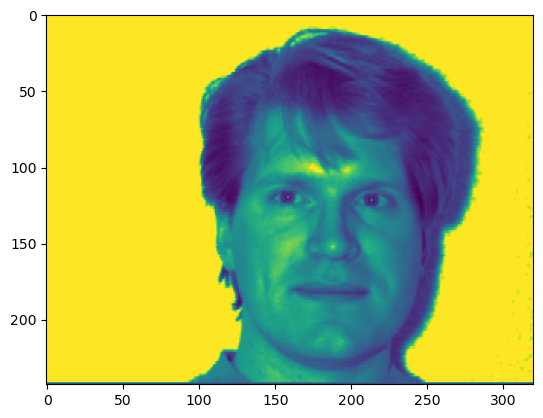

In [2]:
filename = 'yalefaces/subject01.centerlight'
pixels = plt.imread(filename)

rgb_pixels = np.stack((pixels, pixels, pixels), axis = 2)
print(rgb_pixels.shape)

plt.imshow(pixels)
plt.show()

Create the detector to detect only the face in the image

In [3]:
# Create the detector
detector = MTCNN()

# Detect the faces in the image
results = detector.detect_faces(rgb_pixels)

1/1 [==============================] - 0s 349ms/step


Define a function to draw an box around the detected face

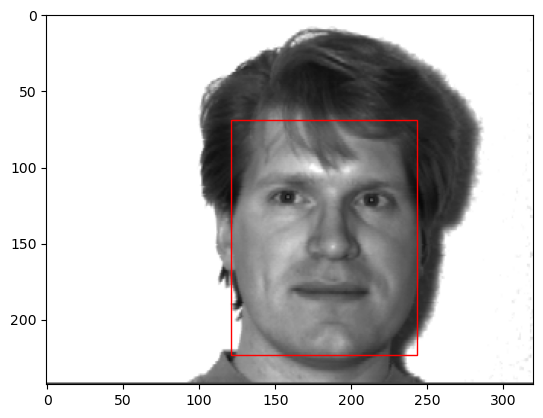

In [4]:
def draw_image_with_boxes(data, face_detection_results):
    plt.imshow(data)
    
    # Get the current axes on the plot
    ax = plt.gca()
    
    for result in face_detection_results:
        # Get the coordinates
        x, y, width, height = result['box']
        
        # Create the shape
        rect = Rectangle((x,y), width, height, fill=False, color='red')
        
        # Draw the rectangle
        ax.add_patch(rect)
        
    plt.show()
    
# Display faces image 'subject01.centerlight'
draw_image_with_boxes(rgb_pixels, results)

Define a function to extract a face from a file

In [5]:
def extract_face_from_file(filename, required_size=(nrows, ncolumns)):
    # Load image from file
    image = Image.open(filename)
    
    return extract_face(image, required_size)

Define a function to extract a face from an image

In [6]:
def extract_face(image, required_size=(nrows, ncolumns)):
    # Convert the image to RGB
    
    image = image.convert('RGB')
    
    # Convert the image to an array
    pixels = np.asarray(image)
    
    # Detect the faces in the image
    results = detector.detect_faces(pixels)
    
    # Get the coordinates of the face
    x1, y1, width, height = results[0]['box']
    
    # Bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # Extract the face
    face = pixels[y1:y2, x1:x2]
    
    # Resize the pixels / image
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image).copy()
    
    gray_face = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)
    
     # Resize image to model size
    face_array[:,:,0] = gray_face
    face_array[:,:,1] = gray_face
    face_array[:,:,2] = gray_face
    
    
    return gray_face

1/1 [==============================] - 0s 44ms/step


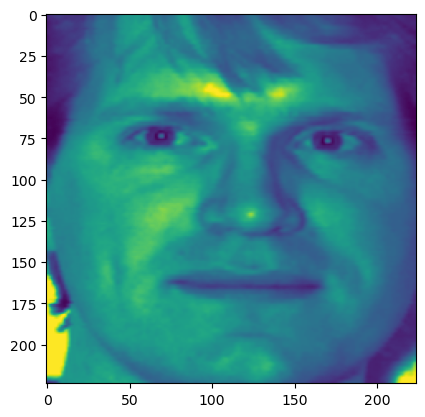

In [7]:
# Load the photo and extract the face
face_pixels = extract_face_from_file("yalefaces/subject01.centerlight")

# Show extracted face
plt.imshow(face_pixels)

#### Applying the logic for all files in the Yale Face database

Define a function to get load and preprocess the data

In [8]:
def load_images(image_directory):
    face_images = []
    i = 1
    for file in os.listdir(image_directory):
        # Load the image from the directory as a PIL image
        image_path = os.path.join(image_directory, file)
        
        # Extract the face using the function extract_face_from_file
        face = extract_face_from_file(image_path) 
        face_images.append(face)
    return face_images

# Load images in the directory yalefaces
yale_faces = load_images('yalefaces')

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 187ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 42ms/step


#### Setup the dataset into training and testing data

Load the file data into different lists

In [9]:
subject_numbers = []
file_names = []
categories  = []
# Get the list of filenames
for file in os.listdir('yalefaces'):
        # Add the subject number, filename and category to seperate lists
        file_names.append(file)
        categories.append(file.split(".")[1])
        subject_numbers.append(file.split(".")[0].replace('subject0','').replace('subject',''))

Create a pandas DataFrame from the lists

In [10]:
faces_dict = {'Subject':subject_numbers, 'Category':categories, 'File':file_names}
faces_df = pd.DataFrame(faces_dict, columns = ['Subject', 'Category','File'])
faces_df.head()

,Subject,Category,File
0,1,centerlight,subject01.centerlight
1,1,glasses,subject01.glasses
2,1,happy,subject01.happy
3,1,leftlight,subject01.leftlight
4,1,noglasses,subject01.noglasses


Set the sizes of the test and training datasets

In [11]:
training_set_count = 8
class_count = len(faces_df["Subject"].unique())
dataset_size = faces_df["Category"].count()
test_size = 1 - (training_set_count * class_count / dataset_size)

Define the X and Y columns that will be used for testing and training

In [12]:
y = faces_df['Subject']
X = faces_df.drop('Subject', axis = 1)

X_train_info, X_test_info, y_train, y_test = train_test_split(
    X, y, test_size = test_size, random_state = 45, stratify = y)

Load the X_test and X_train data

In [13]:
def load_images_dataset(image_directory, dataset):
    face_images = []
    for filename in dataset["File"]:
        # Load the image from the directory as a PIL image
        image_path = os.path.join(image_directory, filename)
        
        # Extract the face using the function extract_face_from_file
        face = extract_face_from_file(image_path) 
        face_images.append(face)
        
    return np.asarray(face_images)

In [14]:
X_test = load_images_dataset('yalefaces', X_test_info)
X_train = load_images_dataset('yalefaces', X_train_info)

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 46ms/step


Reshape and normalize the data

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer

# Normalize the input vectors and labels
in_encoder = Normalizer(norm='l2')

# Reshape X_train
X_train_reshaped = X_train.reshape(X_train.shape[0],
                                   X_train.shape[1]*X_train.shape[2])
print('Reshaped X_train', X_train_reshaped.shape)
X_train_reshaped = in_encoder.transform(X_train_reshaped)

# Reshape X_test
X_test_reshaped = X_test.reshape(X_test.shape[0],
                                 X_test.shape[1]*X_test.shape[2])
print('Reshaped X_test', X_test_reshaped.shape)
X_test_reshaped = in_encoder.transform(X_test_reshaped)

#Normalize labels
out_encoder = LabelEncoder()
out_encoder.fit(y_train)

Reshaped X_train (120, 50176)
Reshaped X_test (45, 50176)


LabelEncoder()

### Hustling

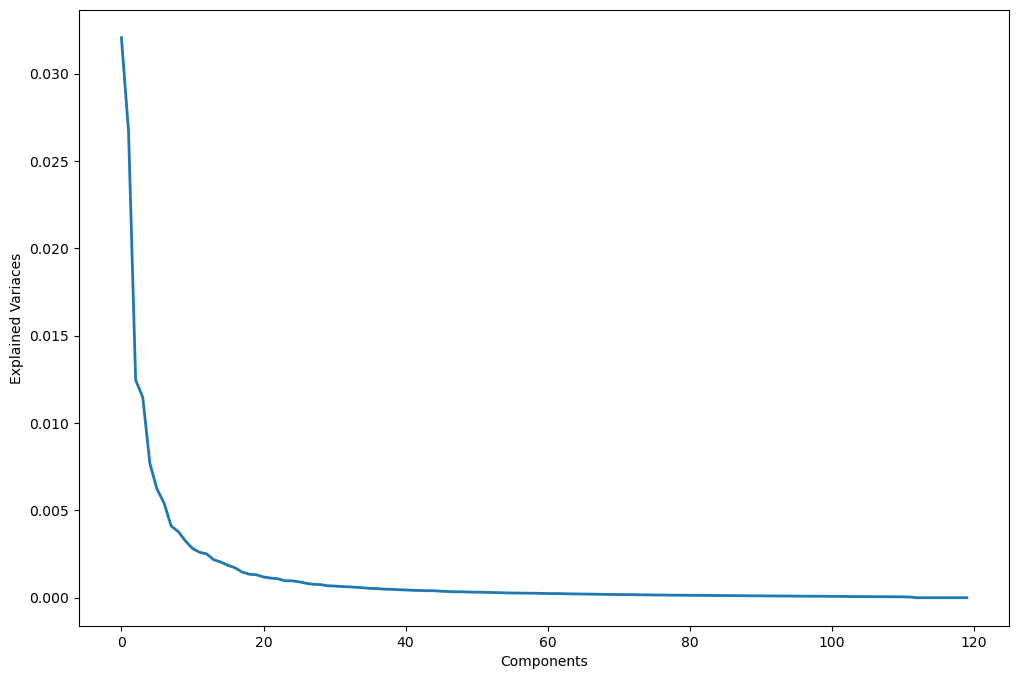

In [19]:
pca=PCA()

# Learns the components and explained variance from the data
pca.fit(X_train_reshaped)

# Set up subplot
plt.figure(1, figsize=(12,8))

# Testing for multiple values
plt.plot(pca.explained_variance_, linewidth=2)

# Set subplot labels
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

In [20]:
n_components=60

In [21]:
# Apply number of components to PCA model
pca=PCA(n_components=n_components, whiten=True)
pca.fit(X_train_reshaped)

PCA(n_components=60, whiten=True)

Text(0.5, 1.0, 'Average Face')

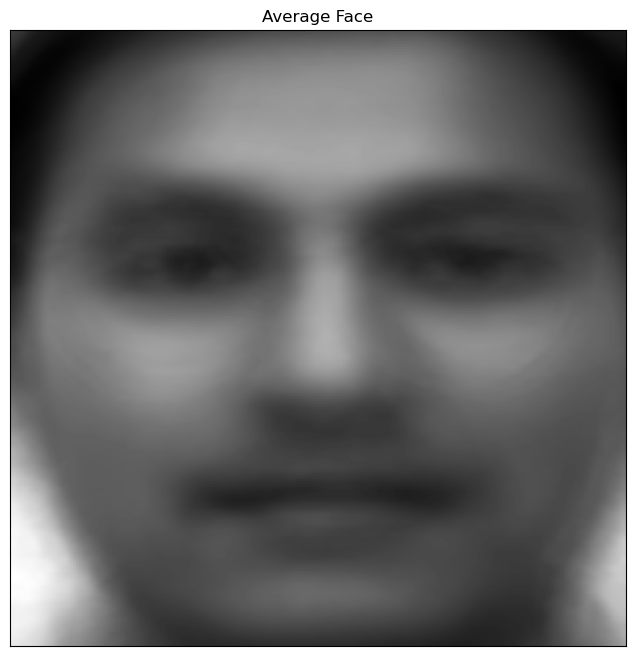

In [198]:
# Set up subplot
fig,ax=plt.subplots(1,1,figsize=(8,8))

# Per-feature mean, estimated from the training set. i.e Average face in dataset
ax.imshow(pca.mean_.reshape((224,224)), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

Text(0.5, 0.98, 'All Eigen Faces')

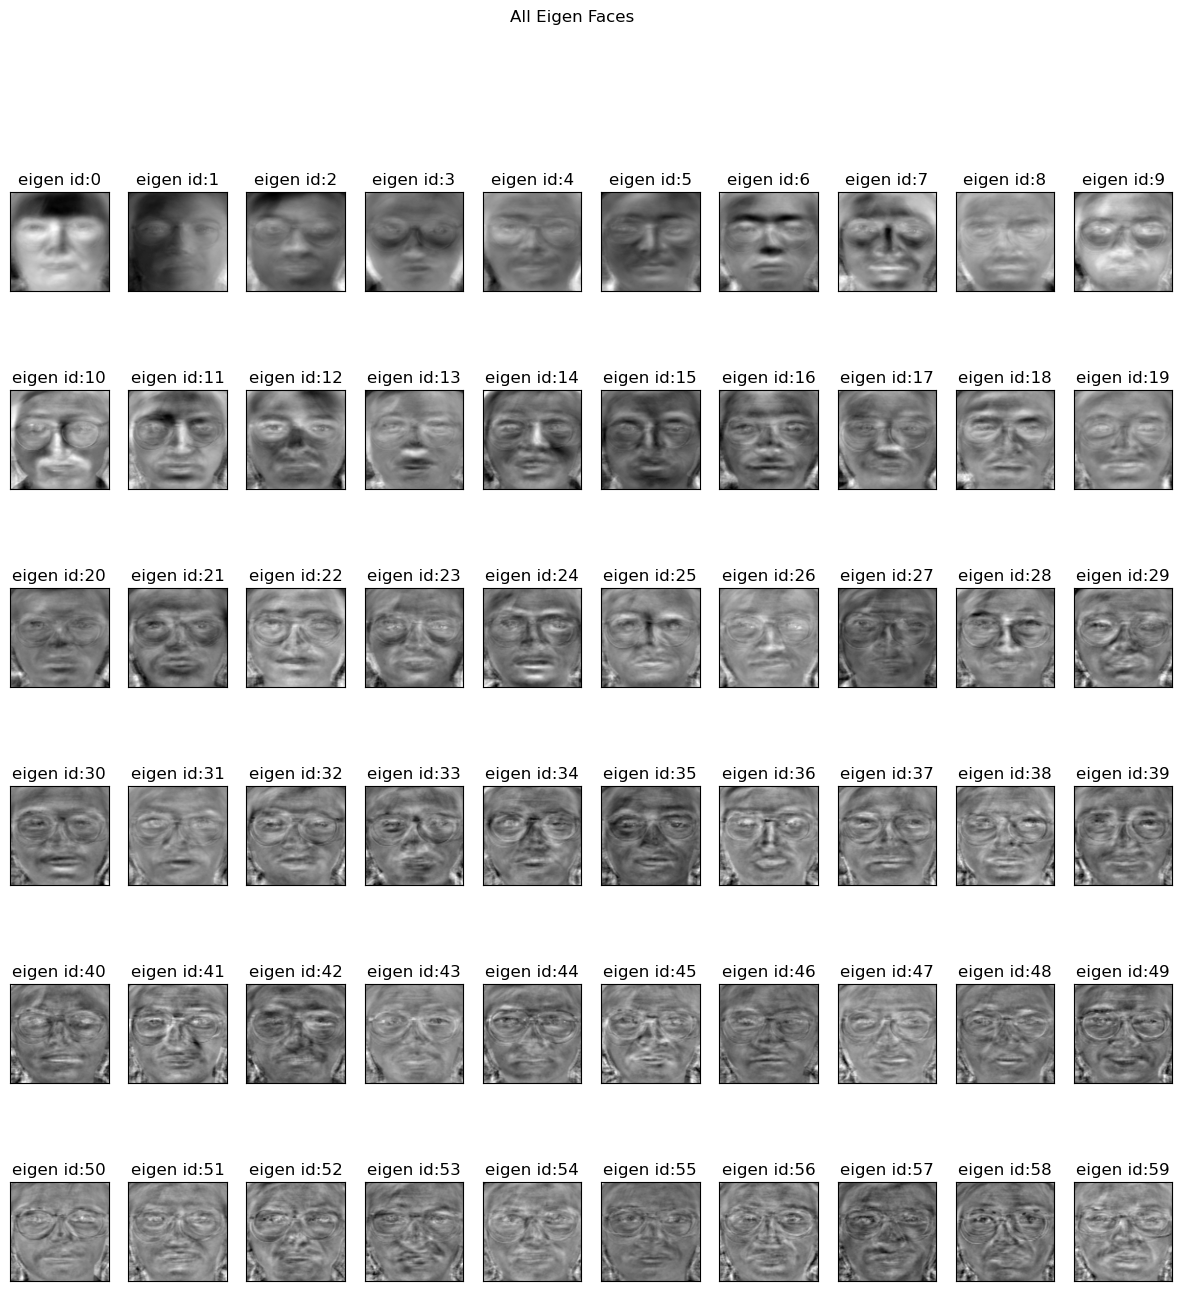

In [200]:
# Get number of eigenfaces
number_of_eigenfaces=len(pca.components_)

# Get eigen faces and shape to appropeite size ready for model predictions
eigen_faces=pca.components_.reshape((number_of_eigenfaces, 224, 224))

# Set up subplot
cols=10
rows=int(number_of_eigenfaces/cols)
fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

# Collapse to 1D array
axarr=axarr.flatten()

# Iterate through eigen faces
for i in range(number_of_eigenfaces):
    axarr[i].imshow(eigen_faces[i],cmap="gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("eigen id:{}".format(i))
plt.suptitle("All Eigen Faces".format(10*"=", 10*"="))

### Part 2: Eigenface Generation (20 points)

In [65]:
image = Image.open('yalefaces/subject01.centerlight')
nrows, ncolumns = image.height, image.width

Calculate the average face image

In [174]:
# Get the length of the images array
length_dataset = X_train_reshaped.shape[0]

mean_face = np.sum(X_train_reshaped, axis=0, dtype='float64') / length_dataset

Find the mean matrix using the numpy tile function. np.tile constructs an array by repeating a given dataset by the number of times specified

In [175]:
mean_matrix = np.tile(mean_face, (length_dataset, 1))

Mean-center the image data. Mean-centering calculates the difference between the mean value and the actual value, ensuring that we are only looking at the variance in the dataset

In [173]:
X_centered = X_train_reshaped - mean_matrix

Caclulate the co-variance in the data. Convariance is a measure of the relationship between two variables.

In this case, we calculate the co-variance by finding the dot product of the image data and a transposed version of the image data

In [178]:
covariance_matrix = (X_centered.dot(X_centered.T)) / length_dataset

Find the eigenvalues and eigenvectors using the covariance matrix. Because they are square and symmetrical, covariance matrixes are diagonalizable, which means an eigendecomposition can be performed on the matrix.

In [179]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

Convert the complex numbers to real numbers

In [180]:
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

Find the order of the eignevalues

In [181]:
order = np.real(eigenvalues).argsort()[::-1]

Sort the eigenvalues by their order

In [182]:
eigenvalues = eigenvalues[order]

Get the principal components

In [183]:
eigenvectors_C = eigenvectors[:, order]

Project all images to the eigen space

In [184]:
eigenvectors_C = X_centered.T @ eigenvectors 

Normalize all the eigenfaces

In [185]:
eigenfaces = preprocessing.normalize(eigenvectors_C.T)

Plot the first eigenface

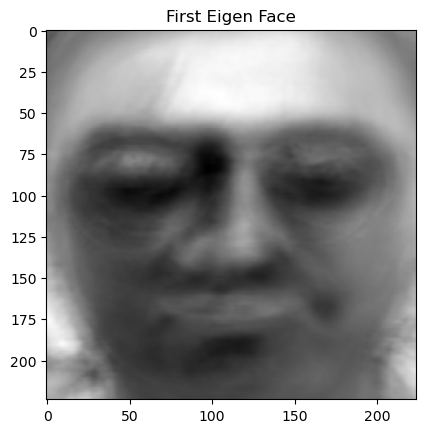

In [202]:
plt.imshow(np.resize(eigenfaces[0], (224,224)), cmap='gray')
plt.title('First Eigen Face')
plt.show()